# Split Dataset into Train, Validation and Test Sets

## Imports and setup

In [14]:

import sys, os
sys.path.append(os.path.abspath(".."))  # go one level up (project root)

import glob
import numpy as np
from sklearn.model_selection import train_test_split
from dataset.bp_dataset import get_dataloader

import torch
from torch.utils.data import Subset, DataLoader, TensorDataset

import matplotlib.pyplot as plt



In [5]:
all_files = sorted(glob.glob("../data/processed/*_ppg_only.npz"))
print(f"Total files found: {len(all_files)}")

Total files found: 12


## Split files into train, validation and test sets

In [8]:
# Load all processed files (use _ppg_only or _ppg_ecg)
npz_files = sorted(glob.glob("../data/processed/*_ppg_only.npz"))

X_list, y_list = [], []
for file in npz_files:
    data = np.load(file)
    X_list.append(data["X"])
    y_list.append(data["y"])

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(f"Total segments: {len(X)}")
print("X shape:", X.shape)
print("y shape:", y.shape)


Total segments: 3507740
X shape: (3507740, 375)
y shape: (3507740, 2)


In [9]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 2455418 | Val: 526161 | Test: 526161


## Create DataLoaders

In [11]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# Add channel dimension if PPG-only
if X_train_t.ndim == 2:
    X_train_t = X_train_t.unsqueeze(1)
    X_val_t = X_val_t.unsqueeze(1)
    X_test_t = X_test_t.unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

## Sanity checks

Check for NaN values in the datasets

In [12]:
print("NaN in X:", np.isnan(X).any())
print("NaN in y:", np.isnan(y).any())


NaN in X: False
NaN in y: False


Check SBP and DBP ranges in the datasets

In [13]:
print("SBP range:", y[:, 0].min(), "-", y[:, 0].max())
print("DBP range:", y[:, 1].min(), "-", y[:, 1].max())

SBP range: 55.291472023101285 - 199.51859203801246
DBP range: 50.0 - 191.42117116588557


## Remove outliers based on SBP and DBP ranges

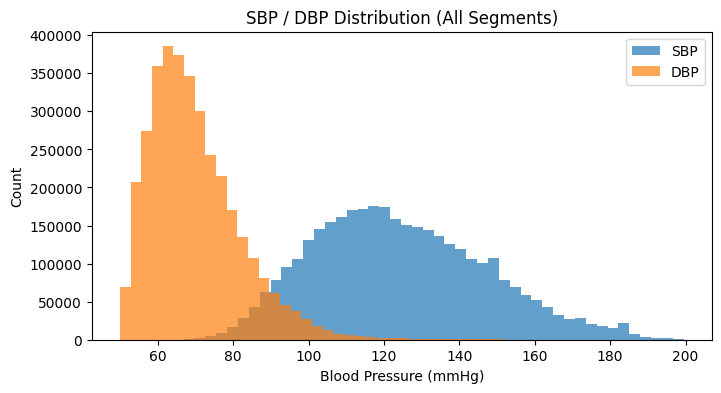

In [15]:
# Visualize distributions
plt.figure(figsize=(8, 4))
plt.hist(y[:, 0], bins=50, alpha=0.7, label="SBP")
plt.hist(y[:, 1], bins=50, alpha=0.7, label="DBP")
plt.xlabel("Blood Pressure (mmHg)")
plt.ylabel("Count")
plt.legend()
plt.title("SBP / DBP Distribution (All Segments)")
plt.show()

In [ ]:
print(f'Segments before cleaning: {len(X)}')

# Remove outliers based on SBP and DBP ranges
mask = (y[:, 0] >= 80) & (y[:, 0] <= 180) & (y[:, 1] >= 50) & (y[:, 1] <= 120)
X = X[mask]
y = y[mask]

print(f"Remaining segments after cleaning: {len(X)} | Removed: {len(mask) - np.sum(mask)} segments")

Segments before cleaning: 3507740
Remaining segments after cleaning: 3425883 | Removed: 81857   segments
